## Simulator

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 100000/100000 [00:49<00:00, 2040.68it/s]


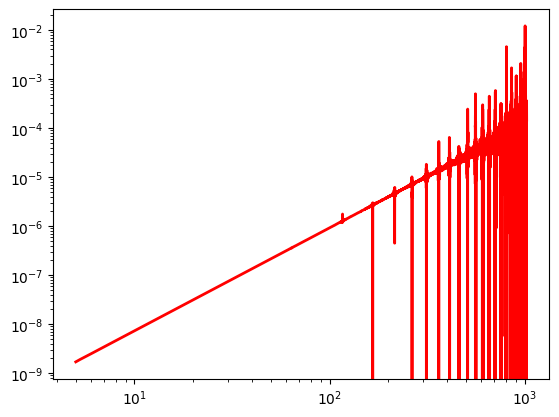

In [2]:
# Simluate data 

fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100000) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

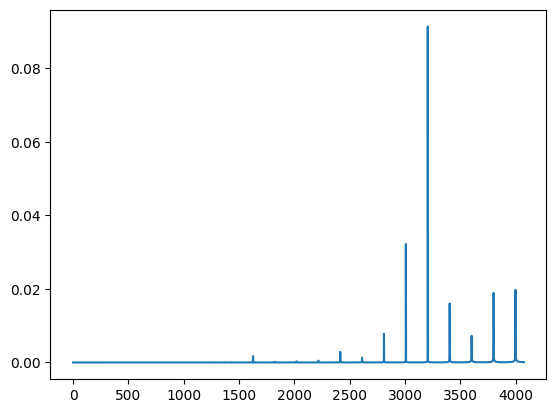

In [3]:
plt.plot(samples[5]['sigma'])

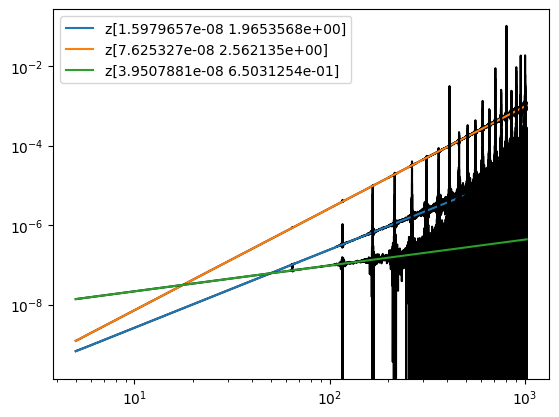

In [4]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [5]:
samples['x']

array([[ 8.29684099e-10,  9.27888322e-10,  1.00943109e-09, ...,
         3.04657169e-05, -1.11947746e-04, -7.59497707e-05],
       [ 1.48830219e-08,  1.56914020e-08,  1.65101461e-08, ...,
        -2.44747673e-04,  1.22203288e-04, -5.46728916e-05],
       [ 1.23758415e-09,  1.39030232e-09,  1.57383984e-09, ...,
         1.07381085e-03,  8.55653838e-04,  8.02618859e-04],
       ...,
       [ 3.51822627e-10,  4.05373651e-10,  4.71303441e-10, ...,
         5.93924895e-04,  7.45655503e-04,  7.64238124e-04],
       [ 1.75671672e-10,  2.15537602e-10,  2.51746346e-10, ...,
         4.24157828e-04,  3.98421660e-04,  3.48166155e-04],
       [ 9.30027166e-09,  9.85025661e-09,  1.03956284e-08, ...,
        -5.24765201e-05,  1.27657104e-05, -1.27595224e-04]], dtype=float32)

## Variational Autoencoder

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4076, 256)
        self.encoder_fc2 = nn.Linear(256, 64)
        self.encoder_fc3 = nn.Linear(64, 16)

        # Latent space mean and log variance
        self.fc_mu = nn.Linear(16, 8)
        self.fc_logvar = nn.Linear(16, 8)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(8, 16)
        self.decoder_fc2 = nn.Linear(16, 64)
        self.decoder_fc3 = nn.Linear(64, 256)
        self.decoder_fc4 = nn.Linear(256, 4076)

        self.dropout = nn.Dropout(0.2)

    def encode(self, x):
        # Encode input to latent space
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        x = F.relu(self.encoder_fc3(x))

        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z

    def decode(self, z):
        # Decode the sampled latent vector
        z = F.relu(self.decoder_fc1(z))
        z = F.relu(self.decoder_fc2(z))
        z = F.relu(self.decoder_fc3(z))
        z = self.decoder_fc4(z)
        return z

    def forward(self, x):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


# Instantiate and print summary
model = VAE()
summary(model, input_size=(1, 4076))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]       1,043,712
            Linear-2                [-1, 1, 64]          16,448
            Linear-3                [-1, 1, 16]           1,040
            Linear-4                 [-1, 1, 8]             136
            Linear-5                 [-1, 1, 8]             136
           Dropout-6                 [-1, 1, 8]               0
            Linear-7                [-1, 1, 16]             144
            Linear-8                [-1, 1, 64]           1,088
            Linear-9               [-1, 1, 256]          16,640
           Linear-10              [-1, 1, 4076]       1,047,532
Total params: 2,126,876
Trainable params: 2,126,876
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 8.11
Estimat

In [7]:
# Pre-Process Data

from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

x_samples = samples['x'] 
m_samples = samples['m']

# Scaling data across each sample (need to transpose first)
transposed_x = x_samples.T
transposed_m = m_samples.T

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_T_scaled = scaler.fit_transform(transposed_x)
m_T_scaled = scaler.fit_transform(transposed_m)

x_scaled = x_T_scaled.T
m_scaled = m_T_scaled.T

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)

from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35201/1400431775.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
x_train_tensor.shape

torch.Size([90000, 4076])

In [9]:
# Check that normalization worked
print("Min: ",np.min(x_scaled[0,:]))
print("Max: ",np.max(x_scaled[0,:]))
print("Mean: ",np.average(x_scaled[0,:]))
print("Var: ", np.var(x_scaled[0,:]))

Min:  -35.161434
Max:  38.746117
Mean:  -1.8717847e-09
Var:  1.0


In [10]:
x_train.shape

(90000, 4076)

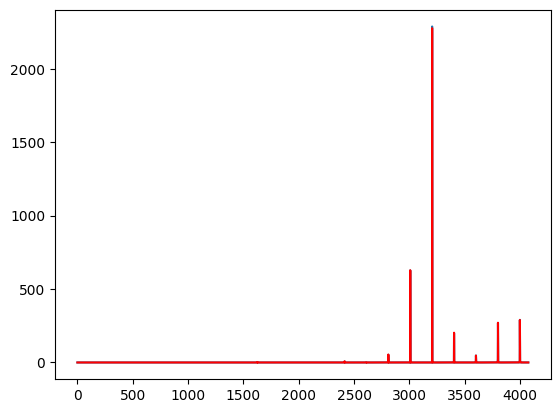

In [11]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = Var_By_Column(x_test)
sig_train = Var_By_Column(x_train)

plt.plot(sig_test)
plt.plot(sig_train, c="r")

In [12]:
# VAE Weighted Loss
def VAE_WeightedLoss(sigma, predictions, targets, mu, logvar):
    """
    Computes the total loss for a Variational Autoencoder (VAE), including:
    - Weighted Mean Squared Error (MSE) loss between predictions and targets.
    - Kullback-Leibler Divergence (KL divergence) to regularize the latent space.
    
    Args:
        sigma (list or torch.Tensor): The variance weights for each dimension.
        predictions (torch.Tensor): The reconstructed values from the VAE.
        targets (torch.Tensor): The target (original input) values.
        mu (torch.Tensor): The mean of the latent space distribution.
        logvar (torch.Tensor): The log variance of the latent space distribution.
        
    Returns:
        torch.Tensor: The total loss, combining weighted MSE loss and KL divergence.
    """
    #ensure sigma is a tensor if it is not already
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.Tensor(sigma)

    #ensure predictons and targets have same shape
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    # Weighted Mean Squared Error loss
    squared_error = 1 / sigma**2 * (predictions - targets)**2
    weighted_mse_loss = torch.mean(squared_error)

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: MSE + KL divergence
    total_loss = weighted_mse_loss + kl_divergence

    return total_loss


Epoch [1/50], Loss: 4773.0156207899
Epoch [2/50], Loss: 2059.5357142795
Epoch [3/50], Loss: 1774.4803247179
Epoch [4/50], Loss: 1570.1890867839
Epoch [5/50], Loss: 1434.5960977648
Epoch [6/50], Loss: 1320.7638305122
Epoch [7/50], Loss: 1250.9667688802
Epoch [8/50], Loss: 1180.8446162001
Epoch [9/50], Loss: 1126.2175696181
Epoch [10/50], Loss: 1075.9998004774
Epoch [11/50], Loss: 1033.7323980035
Epoch [12/50], Loss: 1000.7556977431
Epoch [13/50], Loss: 962.2480672526
Epoch [14/50], Loss: 940.6388309787
Epoch [15/50], Loss: 915.1849004449
Epoch [16/50], Loss: 871.4831514865
Epoch [17/50], Loss: 848.2767132921
Epoch [18/50], Loss: 837.7522134494
Epoch [19/50], Loss: 804.5422843913
Epoch [20/50], Loss: 787.0876769314
Epoch [21/50], Loss: 761.3371679362
Epoch [22/50], Loss: 750.7611592556
Epoch [23/50], Loss: 727.6092266059
Epoch [24/50], Loss: 708.3912578830
Epoch [25/50], Loss: 693.7731743273
Epoch [26/50], Loss: 679.1344638075
Epoch [27/50], Loss: 667.8454901747
Epoch [28/50], Loss: 662.

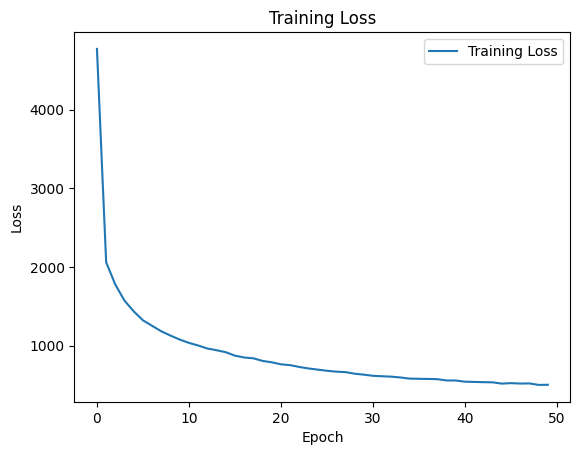

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Variational Autoencoder
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate
sig_train = sig_train  # list of variances per feature

train_losses = []
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass through the VAE
        outputs, mu, logvar = model(inputs.unsqueeze(1))  # Outputs, mu, logvar

        # Compute the loss
        loss = VAE_WeightedLoss(sig_train, outputs, targets.unsqueeze(1), mu, logvar)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * inputs.size(0)

    # Compute the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")

# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [14]:
torch.save(model,'VAE_model_pytorch.pt')

In [15]:
model = torch.load('VAE_model_pytorch.pt')
model.eval()  
test_loss = 0.0

with torch.no_grad():  #disable gradient calculation for evaluation
    for inputs, targets in test_loader:

        outputs, mu, logvar = model(inputs.unsqueeze(1))
        loss = VAE_WeightedLoss(sig_test, outputs, targets.unsqueeze(1), mu, logvar)
        test_loss += loss.item() * inputs.size(0)

# average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 1601.3543


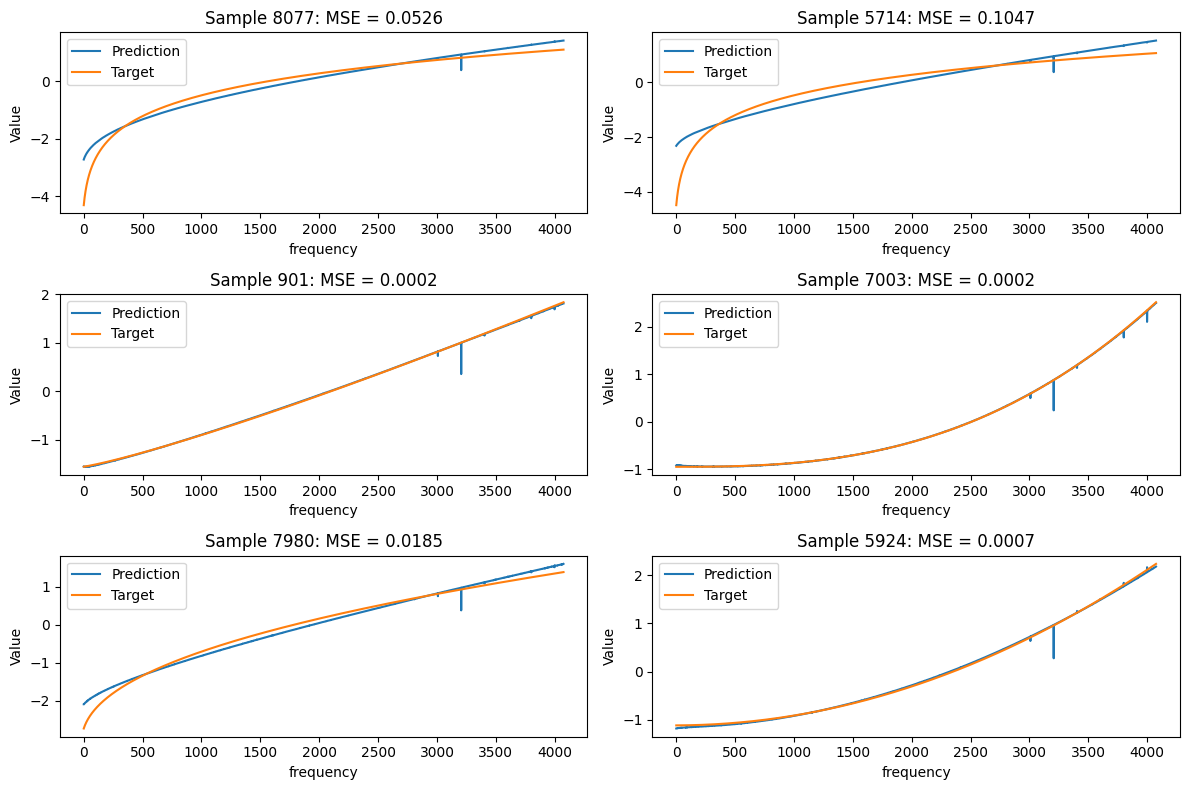

In [32]:
import random
import matplotlib.pyplot as plt

# Randomly select 6 indices
num_samples = 6
random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 3
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0))  # extract prediction from model output

    mse = F.mse_loss(prediction.squeeze(), target).item() # calculate error

    # Plot prediction and target
    axs[row, col].plot(prediction.squeeze().numpy(), label='Prediction')
    axs[row, col].plot(target.numpy(), label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


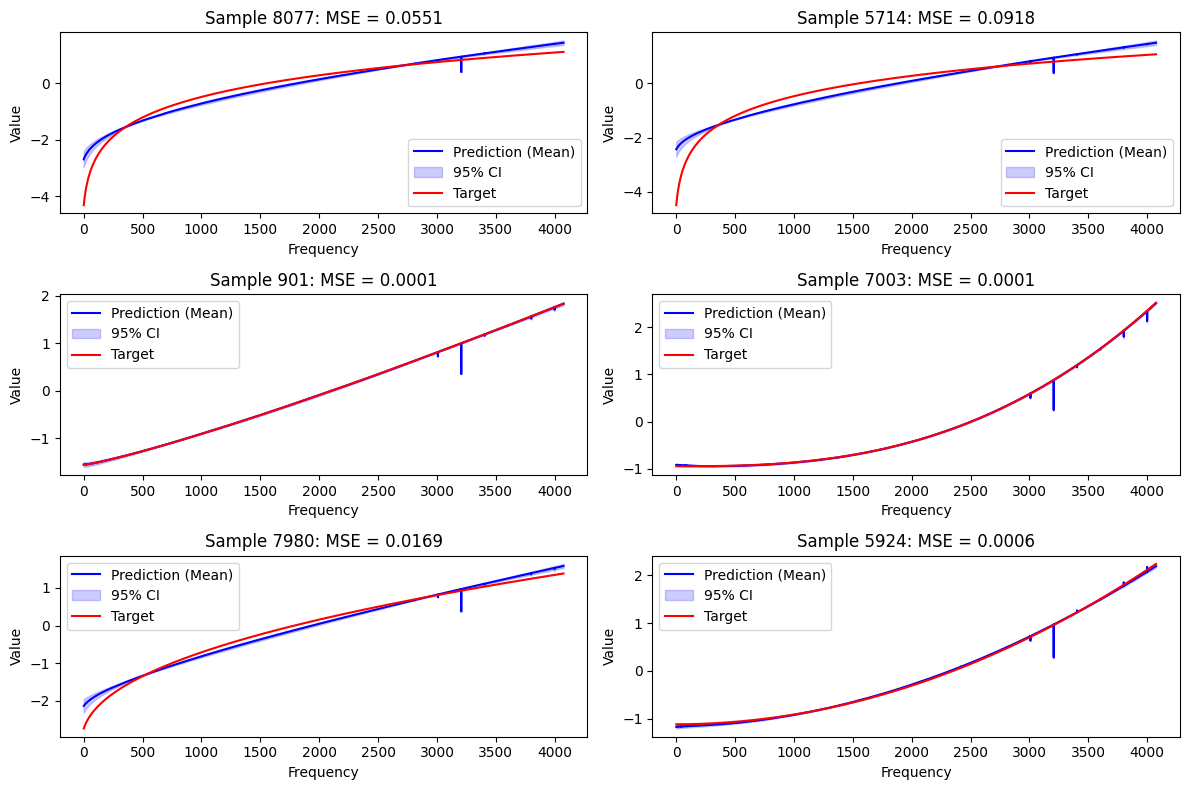

In [37]:
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]
    samples = []

    for _ in range(1000):  # Simulate 10,000 model outputs
        with torch.no_grad():
            model.eval()
            prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0)) 
        samples.append(prediction.squeeze().numpy())  # Convert to numpy and store

    # Convert the list of samples to a numpy array for easier calculations
    samples = np.array(samples)

    samples_mean = np.mean(samples, axis=0)

    samples_std = np.std(samples, axis=0)
     # Compute the 95% confidence interval (mean ± 1.96 * standard deviation)
    ci_lower = samples_mean - 1.96 * samples_std
    ci_upper = samples_mean + 1.96 * samples_std


    mse = F.mse_loss(torch.tensor(samples_mean), target).item()

   
    # Plot prediction and target
    axs[row, col].plot(samples_mean, label='Prediction (Mean)', color='blue')
    axs[row, col].fill_between(range(len(samples_mean)), ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    axs[row, col].plot(target.numpy(), label='Target', color='red')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()